# VGG19 model on Flickr Material Database

In [1]:
import keras
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow.keras import regularizers
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from keras.applications.resnet import preprocess_input
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
import time
import os
import sys

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Read data
Read the pre-split train data and test data

In [4]:
# Parse arguments
dataset = 'FMD'
split = 5
n_classes = 10
train_dir = 'DS_FMD/train'.format(dataset, split)
test_dir = 'DS_FMD/test'.format(dataset, split)

In [5]:
# Read data
############ Do some random image transformations to increase the number of training samples
############ Note that we are scaling the image to make all the values between 0 and 1. That's how our pretrained weights have been done too
############ Default batch size is 1 but you can reduce/increase it depending on how powerful your machine is. 
batch_size = 20
img_width = 224
img_height = 224
# Data augmentation
train_datagen = image.ImageDataGenerator(
    preprocessing_function = preprocess_input, #rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = image.ImageDataGenerator(preprocessing_function = preprocess_input)#rescale=1. / 255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 800 images belonging to 10 classes.
Found 200 images belonging to 10 classes.


## Construct the model
Import VGG19 model, remove the pre-trained output layer, and add on the output layer to fit the FMD dataset.

In [6]:
# Build Fine-tune network architecture
# Get Image-Net pre-trained model
vgg19_model = keras.applications.VGG19(input_tensor=Input(shape=(224, 224, 3))) #vgg19.
print("<VGG19 model>")
model = keras.Sequential()
# Remove 1000-classes output layer (last layer)
name_last_layer = str(vgg19_model.layers[-1])

for layer in vgg19_model.layers:
    if str(layer) != name_last_layer:
        model.add(layer)


<VGG19 model>


In [7]:
# Add n_classes output layer for our dataset
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(n_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01),
          bias_regularizer=regularizers.l2(0.01)))

print("<Fine-tuned model>")
model.summary()

<Fine-tuned model>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 5

In [8]:
model_folder = 'DS_FMD_classification/models'
filepath = '{}/fine_tuned_model_{}.h5'.format(model_folder, split)
if not os.path.exists(model_folder):
    os.makedirs(model_folder)


"\nmodel_folder = '/content/drive/My Drive/tensorflow/models'\nfilepath = '{}/fine_tuned_model_{}.h5'.format(model_folder, split)\nif not os.path.exists(model_folder):\n    os.makedirs(model_folder)\n"

## Train model
Adam optimizer with learning rate decay is employed. The model is trained for 30 epochs as it converges fast.

In [9]:
# Config model and train

initial_learning_rate = 0.0001
decay_steps = 1000
decay_rate = 0.9
lr = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate, staircase=False, name=None
)

optimizer = keras.optimizers.Adam(learning_rate=lr, epsilon=0.1)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [10]:
# num_training_img = 24954
# num_validation_img = 9151

# stepsPerEpoch = num_training_img/batch_size
stepsPerEpoch = 800 / batch_size
validationSteps = 200 / batch_size
print("validationSteps: {}".format(validationSteps))
epochs = 30 #200
start_time = time.time()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=stepsPerEpoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validationSteps,
)
print('Execution time: ', time.time() - start_time)

validationSteps: 10.0
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
40/40 [==============================] - 18s 458ms/step - loss: 3.0194 - accuracy: 0.1425 - val_loss: 2.8393 - val_accuracy: 0.2400
Epoch 2/30
40/40 [==============================] - 19s 464ms/step - loss: 2.1820 - accuracy: 0.3262 - val_loss: 2.1214 - val_accuracy: 0.4250
Epoch 3/30
40/40 [==============================] - 18s 459ms/step - loss: 1.5293 - accuracy: 0.5738 - val_loss: 1.7309 - val_accuracy: 0.5500
Epoch 4/30
40/40 [==============================] - 18s 455ms/step - loss: 1.1404 - accuracy: 0.7225 - val_loss: 1.5362 - val_accuracy: 0.6100
Epoch 5/30
40/40 [==============================] - 18s 451ms/step - loss: 0.8947 - accuracy: 0.7850 - val_loss: 1.3887 - val_accuracy: 0.6700
Epoch 6/30
40/40 [==============================] - 18s 454ms/step - loss: 0.7058 - accuracy: 0.8600 - val_loss: 1.3564 - val_accuracy: 0.6800
Epoch 7/30
40/40 [==========================

## Evaluate model

In [11]:
result_folder = "DS_FMD_classification/result/{}".format(dataset)
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
accuracy_file = "{}/acc.csv".format(result_folder)

evaluator = model.evaluate_generator(generator=validation_generator)
loss = evaluator[0]
acc = evaluator[1]

with open(accuracy_file, "a") as fw:
    fw.write("{}, {}, {}\n".format(split, loss, acc))

print("[loss, acc] = {}".format(model.evaluate_generator(generator=validation_generator)))

Instructions for updating:
Please use Model.evaluate, which supports generators.
[loss, acc] = [1.1719878911972046, 0.7850000262260437]


## Plot accuracy and loss curves

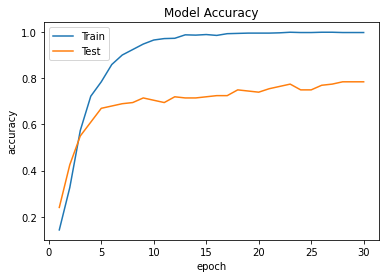

In [12]:
train_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']
# Save the plot for accuracies
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train')
plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

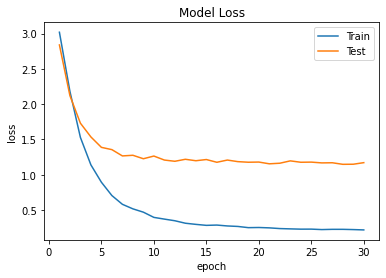

In [13]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
# Save the plot for accuracies
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train')
plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
